# Set up

In [1]:
# IMPORT

import pandas
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

import os
from nltk import wordpunct_tokenize
import re

from nltk.tokenize import word_tokenize
from PIL import Image
import seaborn as sns

import lightning.pytorch as pl
import wandb

/work/hpc/pad/PAD2003-multi-label-movie-genres/envs/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/work/hpc/pad/PAD2003-multi-label-movie-genres/envs/lib/python3.8/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# SEED

torch.manual_seed(1012)
torch.cuda.manual_seed(1012)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(1012)

# Explore data

In [3]:
# read files

movies_train = pandas.read_csv('../data/ml1m/content/dataset/movies_train.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')

movies_test = pandas.read_csv('../data/ml1m/content/dataset/movies_test.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')

# process genres

movies_train['genre'] = movies_train.genre.str.split('|')

movies_test['genre'] = movies_test.genre.str.split('|')

In [4]:
movies_train

title  \
movieid                                 
1650         Washington Square (1997)   
185                   Net, The (1995)   
1377            Batman Returns (1992)   
3204     Boys from Brazil, The (1978)   
1901                Dear Jesse (1997)   
...                               ...   
2539              Analyze This (1999)   
3038      Face in the Crowd, A (1957)   
1832          Heaven's Burning (1997)   
657                Yankee Zulu (1994)   
1750                  Star Kid (1997)   

                                            genre  
movieid                                            
1650                                      [Drama]  
185                            [Sci-Fi, Thriller]  
1377           [Action, Adventure, Comedy, Crime]  
3204                                   [Thriller]  
1901                                [Documentary]  
...                                           ...  
2539                                     [Comedy]  
3038                                      [Drama]  
1832                              [Action, Drama]  
657                               [Comedy, Drama]  
1750     [Adventure, Children's, Fantasy, Sci-Fi]  

[3106 rows x 2 columns]

## Title

In [5]:
def simple_tokenize(text):
  text = re.sub(r'[^\w\s]', '', text)
  text = text.lower()
  tokens = wordpunct_tokenize(text)
  return tokens

movies_train['num_tokens'] = movies_train['title'].apply(lambda x: len(simple_tokenize(str(x))))
max_tokens_count = movies_train['num_tokens'].max()
print(f"Train data : maximum number of tokens : {max_tokens_count}")

movies_test['num_tokens'] = movies_test['title'].apply(lambda x: len(simple_tokenize(str(x))))
max_tokens_count = movies_test['num_tokens'].max()
print(f"Test data  : maximum number of tokens : {max_tokens_count}")

Train data : maximum number of tokens : 16
Test data  : maximum number of tokens : 14


In [6]:
movies_train

title  \
movieid                                 
1650         Washington Square (1997)   
185                   Net, The (1995)   
1377            Batman Returns (1992)   
3204     Boys from Brazil, The (1978)   
1901                Dear Jesse (1997)   
...                               ...   
2539              Analyze This (1999)   
3038      Face in the Crowd, A (1957)   
1832          Heaven's Burning (1997)   
657                Yankee Zulu (1994)   
1750                  Star Kid (1997)   

                                            genre  num_tokens  
movieid                                                        
1650                                      [Drama]           3  
185                            [Sci-Fi, Thriller]           3  
1377           [Action, Adventure, Comedy, Crime]           3  
3204                                   [Thriller]           5  
1901                                [Documentary]           3  
...                                           ...         ...  
2539                                     [Comedy]           3  
3038                                      [Drama]           6  
1832                              [Action, Drama]           3  
657                               [Comedy, Drama]           3  
1750     [Adventure, Children's, Fantasy, Sci-Fi]           3  

[3106 rows x 3 columns]

In [7]:
movies_test

title  \
movieid                                               
3397                 Great Muppet Caper, The (1981)   
2067                          Doctor Zhivago (1965)   
2651         Frankenstein Meets the Wolf Man (1943)   
2989                      For Your Eyes Only (1981)   
3415                   Mirror, The (Zerkalo) (1975)   
...                                             ...   
2309     Inheritors, The (Die Siebtelbauern) (1998)   
2421                Karate Kid, Part II, The (1986)   
3255                  League of Their Own, A (1992)   
974                                  Algiers (1938)   
2555                           Baby Geniuses (1999)   

                              genre  num_tokens  
movieid                                          
3397           [Children's, Comedy]           5  
2067          [Drama, Romance, War]           3  
2651                       [Horror]           6  
2989                       [Action]           5  
3415                        [Drama]           4  
...                             ...         ...  
2309                        [Drama]           5  
2421     [Action, Adventure, Drama]           6  
3255                [Comedy, Drama]           6  
974                [Drama, Romance]           2  
2555                       [Comedy]           3  

[777 rows x 3 columns]

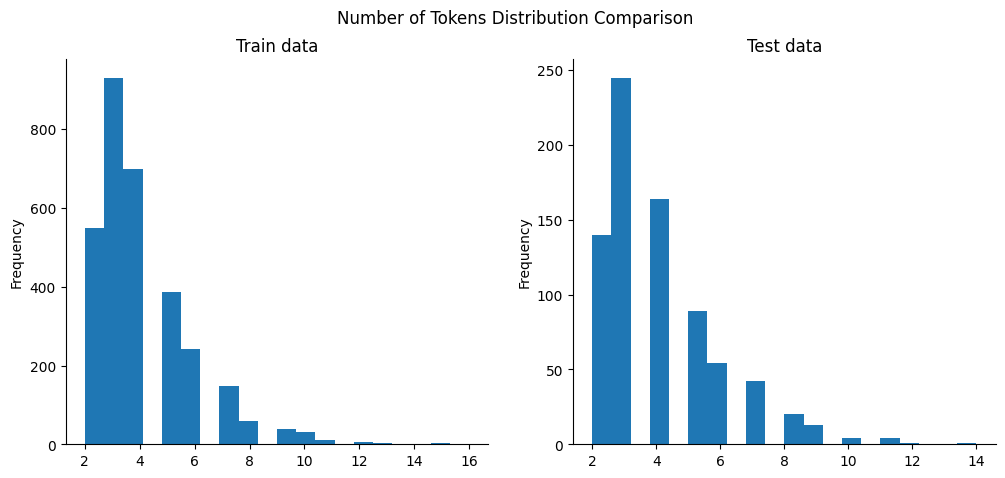

In [8]:
from matplotlib import pyplot as plt

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for movies_train
movies_train['num_tokens'].plot(kind='hist', bins=20, title='Train data', ax=axes[0])
axes[0].spines[['top', 'right']].set_visible(False)

# Plot for movies_test
movies_test['num_tokens'].plot(kind='hist', bins=20, title='Test data', ax=axes[1])
axes[1].spines[['top', 'right']].set_visible(False)

# Set overall title
fig.suptitle('Number of Tokens Distribution Comparison')

# Show the plots
plt.show()


## Images

In [9]:
# get image paths

folder_img_path = '../data/ml1m/content/dataset/ml1m-images'

movies_train['id'] = movies_train.index
# movies_train.reset_index(inplace=True)
movies_train['img_path'] = movies_train.apply(lambda row: os.path.join(folder_img_path, f'{row.id}.jpg') if os.path.exists(os.path.join(folder_img_path, f'{row.id}.jpg')) else '', axis=1)

movies_test['id'] = movies_test.index
# movies_test.reset_index(inplace=True)
movies_test['img_path'] = movies_test.apply(lambda row: os.path.join(folder_img_path, f'{row.id}.jpg') if os.path.exists(os.path.join(folder_img_path, f'{row.id}.jpg')) else '', axis=1)


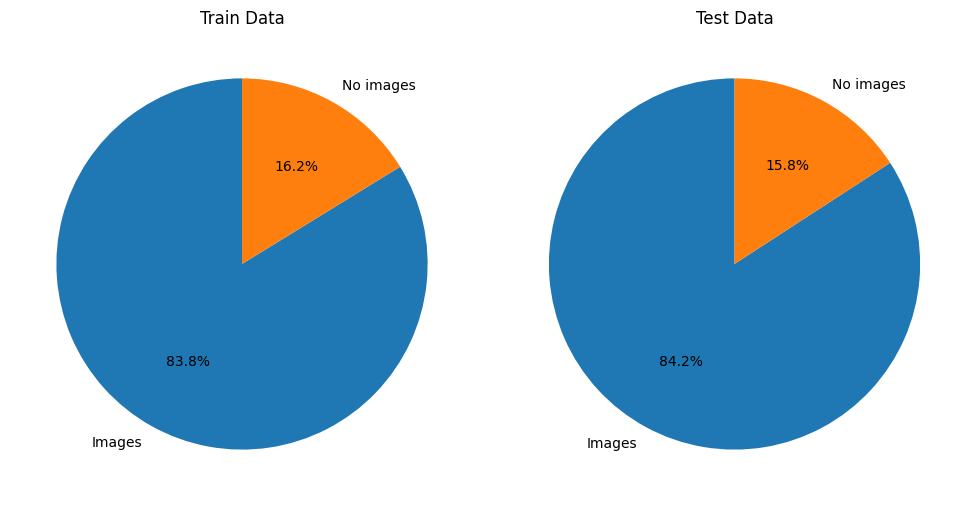

In [10]:
# Plot the pie chart for train and test data side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the pie chart for train data
movies_train['image_exists'] = movies_train.apply(lambda row: 'No images' if row.img_path == '' else 'Images', axis=1)
img_path_counts_train = movies_train['image_exists'].value_counts()
axes[0].pie(img_path_counts_train, labels=img_path_counts_train.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Train Data')

# Plot the pie chart for test data
movies_test['image_exists'] = movies_test.apply(lambda row: 'No images' if row.img_path == '' else 'Images', axis=1)
img_path_counts_test = movies_test['image_exists'].value_counts()
axes[1].pie(img_path_counts_test, labels=img_path_counts_test.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Test Data')

plt.tight_layout()
plt.show()

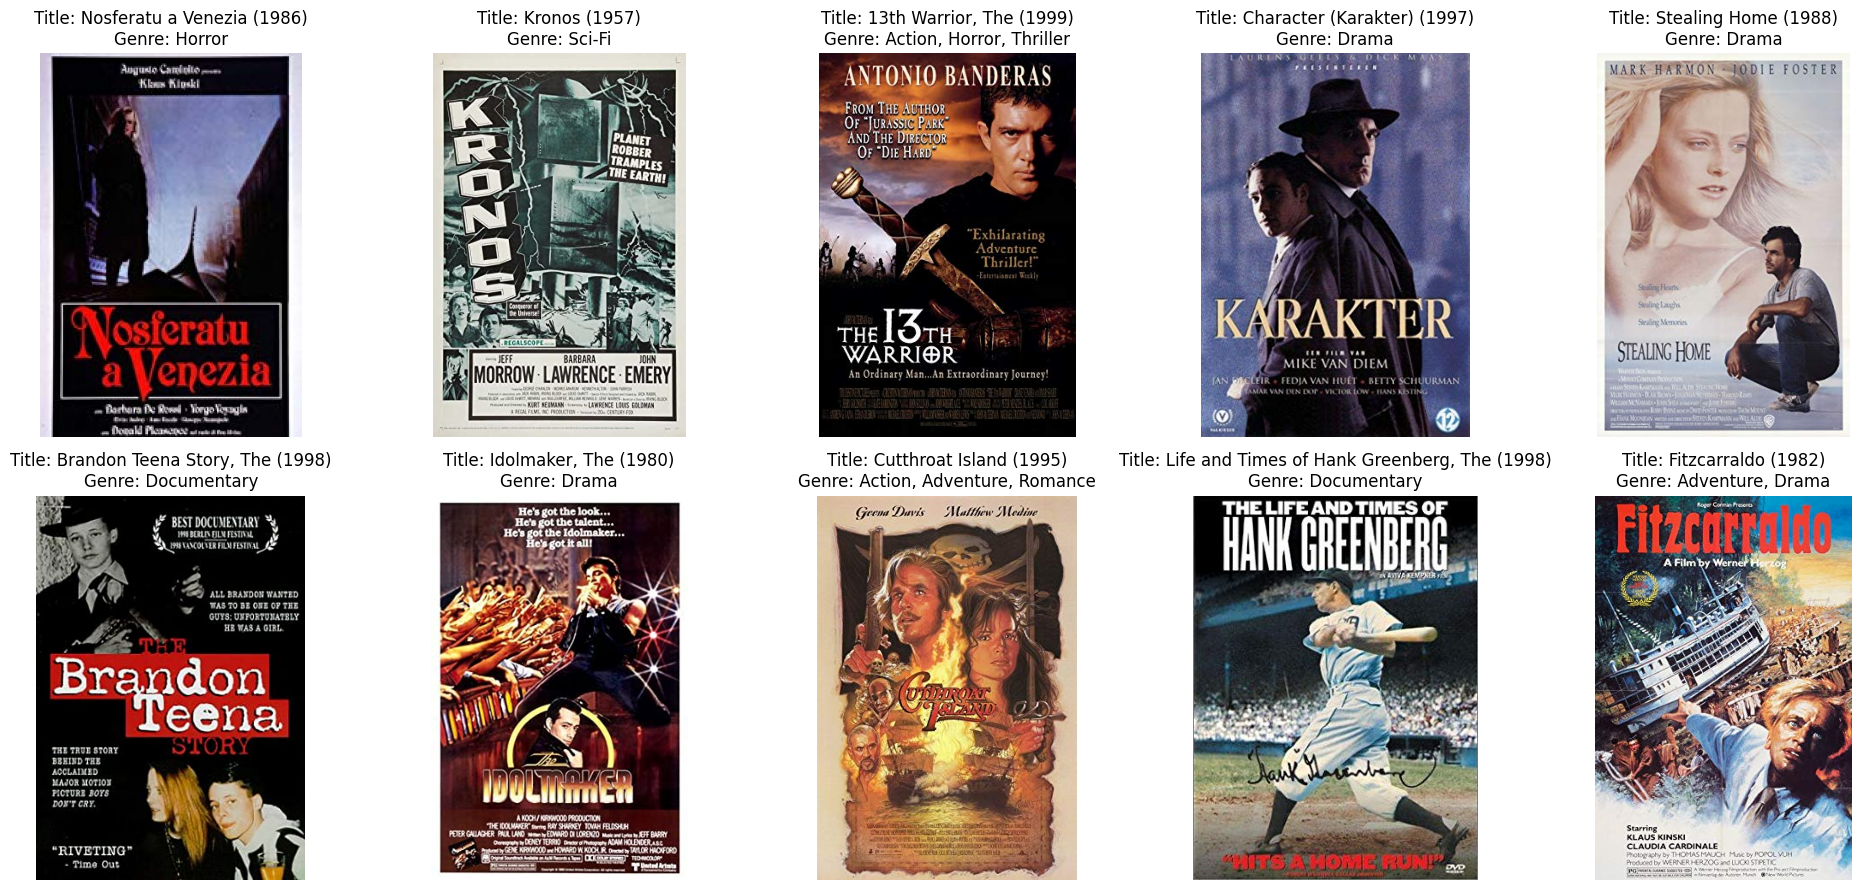

In [11]:
filtered_rows = movies_train[movies_train['img_path'] != '']
selected_rows = filtered_rows.sample(10)

fig, axes = plt.subplots(2, 5, figsize=(20, 9))
for i, (index, row) in enumerate(selected_rows.iterrows()):
    img = Image.open(row['img_path'])
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')
    axes[i // 5, i % 5].set_title(f"Title: {row['title']}\nGenre: {', '.join(row['genre'])}")


plt.tight_layout()
plt.show()

In [12]:
from torchvision.transforms import transforms
custom_transform = transforms.Compose([
                transforms.RandomApply([transforms.RandomRotation(15)], p=0.8),
                transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.5),
                transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)], p=0.7),
                transforms.RandomApply([transforms.RandomResizedCrop(224)], p=0.8),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


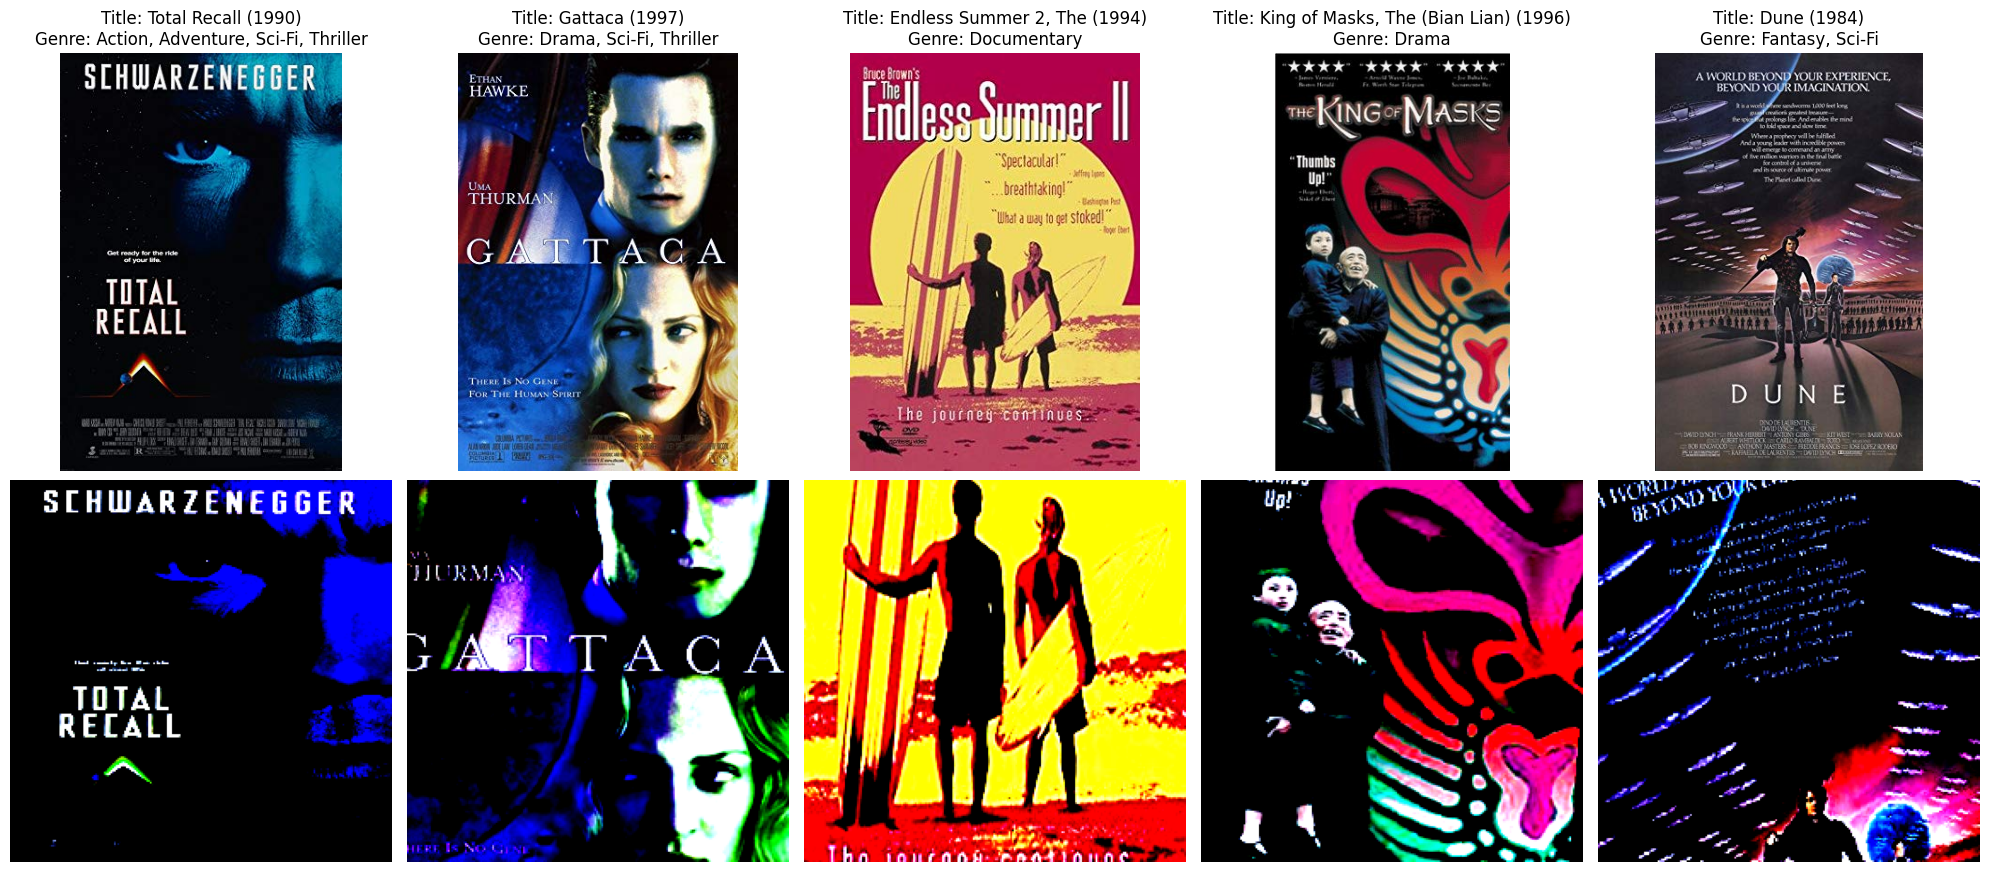

In [13]:
filtered_rows = movies_train[movies_train['img_path'] != '']
selected_rows = filtered_rows.sample(5)

fig, axes = plt.subplots(2, 5, figsize=(20, 9))
for i, (index, row) in enumerate(selected_rows.iterrows()):
    img = Image.open(row['img_path'])
    
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')
    axes[i // 5, i % 5].set_title(f"Title: {row['title']}\nGenre: {', '.join(row['genre'])}")

for i, (index, row) in enumerate(selected_rows.iterrows()):
    img = Image.open(row['img_path'])
    transformed_img = custom_transform(img)
    numpy_img = transformed_img.numpy()
    numpy_img = np.transpose(numpy_img, (1, 2, 0))
    
    axes[i // 5 + 1, i % 5].imshow(numpy_img)
    axes[i // 5 + 1, i % 5].axis('off')


plt.tight_layout()
plt.show()

## Genres

In [14]:
all_genres = movies_train['genre'].explode()
genre_counts = all_genres.value_counts()

print(f"Number of genres: {len(genre_counts)} \n")
print(f"Frequency: \n{genre_counts}")

Number of genres: 18 

Frequency: 
genre
Drama          1294
Comedy          953
Action          413
Thriller        386
Romance         377
Horror          268
Adventure       235
Sci-Fi          228
Children's      203
Crime           180
War             118
Musical         101
Documentary      97
Mystery          88
Animation        84
Fantasy          61
Western          54
Film-Noir        38
Name: count, dtype: int64


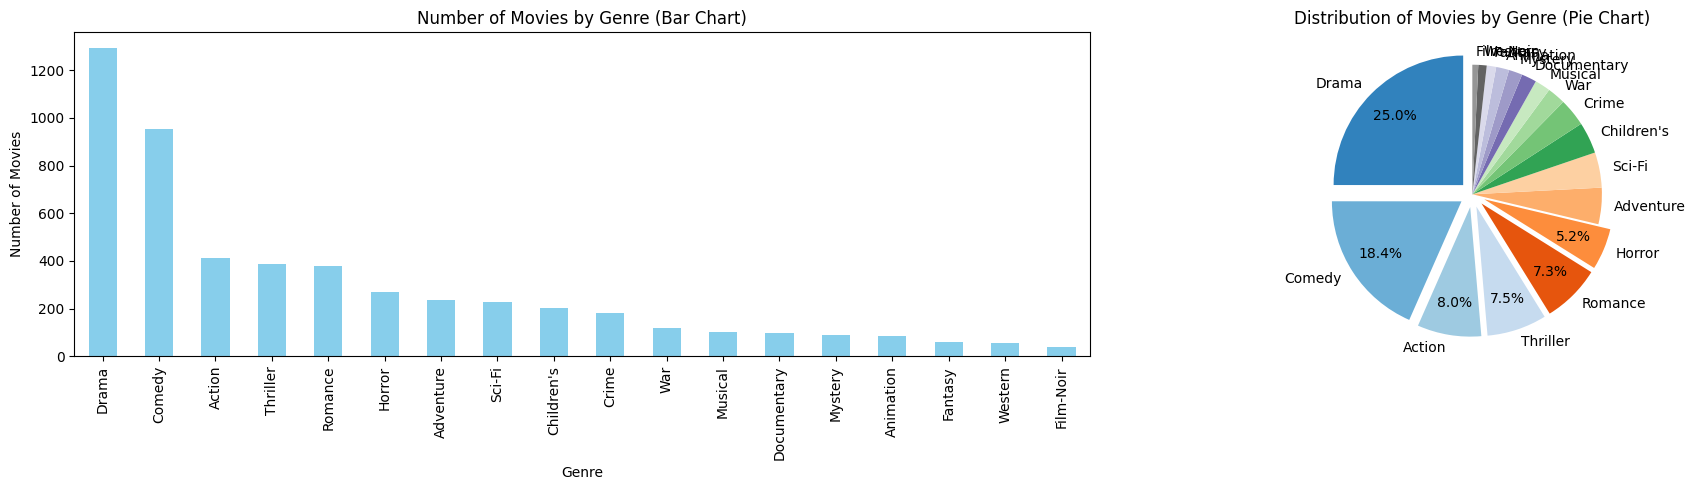

In [15]:
plt.figure(figsize=(20, 5))


# Bar chart
plt.subplot(1, 2, 1)
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Movies by Genre (Bar Chart)')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')

# Pie chart
plt.subplot(1, 2, 2)
explode = (genre_counts / genre_counts.sum() >= 0.05).astype(float) * 0.1
plt.pie(genre_counts, labels=genre_counts.index, autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
        startangle=90, explode=explode, pctdistance=0.75, colors=plt.cm.tab20c.colors)
plt.title('Distribution of Movies by Genre (Pie Chart)')

plt.tight_layout()
plt.show()

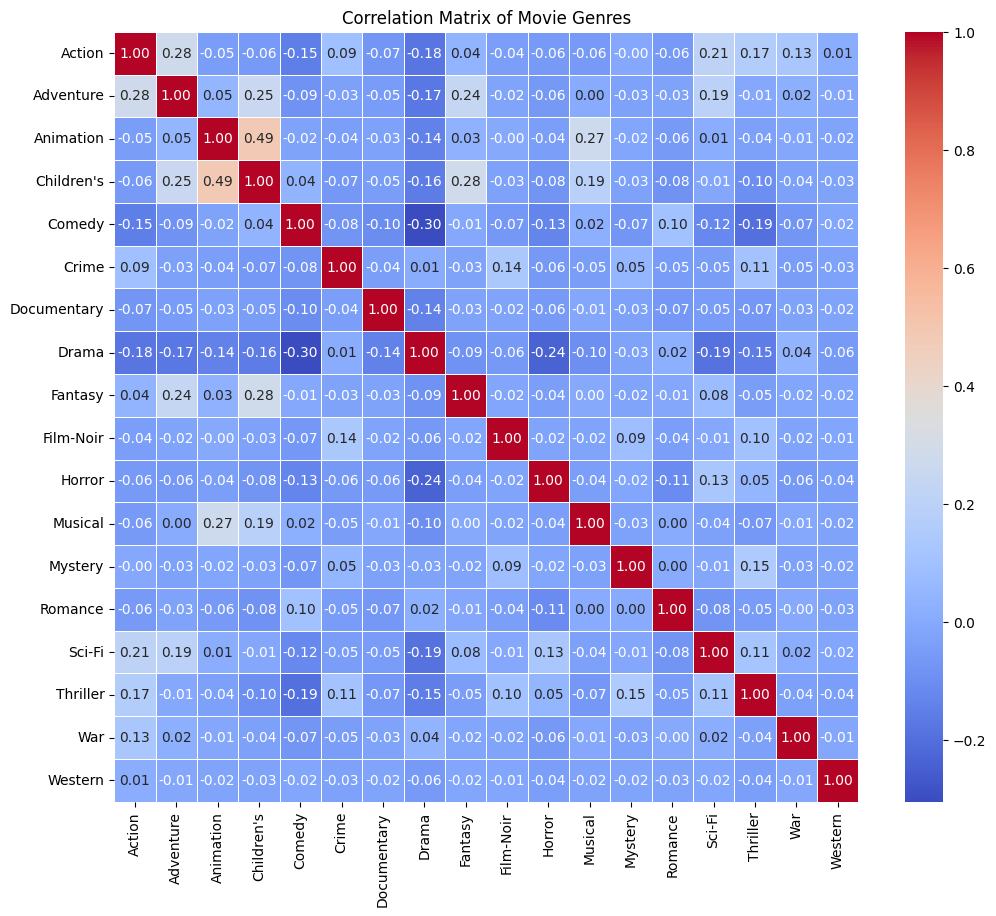

In [16]:
genres_matrix = movies_train['genre'].str.join('|').str.get_dummies('|').corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(genres_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Movie Genres')
plt.show()

In [17]:
threshold = 0.2

strong_correlations = genres_matrix.mask(np.triu(np.ones(genres_matrix.shape), k=1).astype(bool)).stack().sort_values(ascending=False)
filtered_correlations = strong_correlations[(strong_correlations.abs() > threshold) & (strong_correlations.index.get_level_values(0) != strong_correlations.index.get_level_values(1))]

print("Top Strongly Correlated Different Genres:\n")
print(filtered_correlations)

Top Strongly Correlated Different Genres:

Children's  Animation     0.485926
Fantasy     Children's    0.281763
Adventure   Action        0.278786
Musical     Animation     0.271566
Children's  Adventure     0.254375
Fantasy     Adventure     0.240271
Sci-Fi      Action        0.209722
Horror      Drama        -0.236428
Drama       Comedy       -0.304502
dtype: float64


In [18]:
all_genres = movies_test['genre'].explode()
genre_counts = all_genres.value_counts()

print(f"Number of genres: {len(genre_counts)} \n")
print(f"Frequency: \n{genre_counts}")

Number of genres: 18 

Frequency: 
genre
Drama          309
Comedy         247
Thriller       106
Romance         94
Action          90
Horror          75
Children's      48
Adventure       48
Sci-Fi          48
Crime           31
Documentary     30
War             25
Animation       21
Mystery         18
Western         14
Musical         13
Fantasy          7
Film-Noir        6
Name: count, dtype: int64


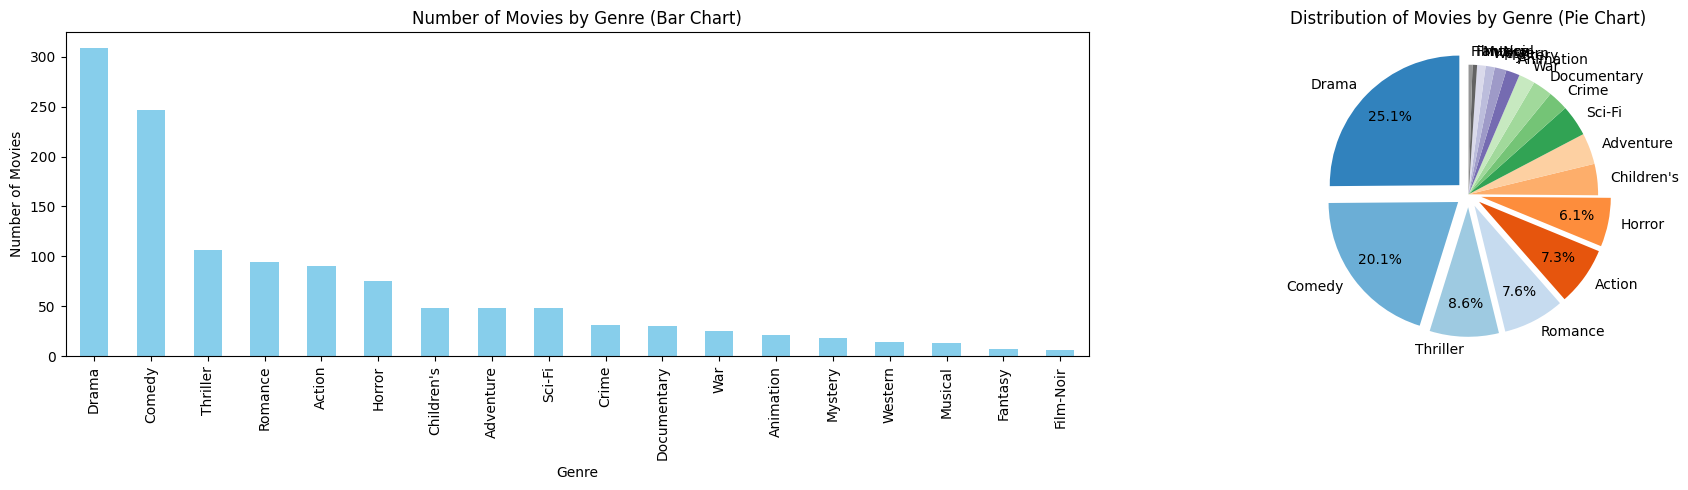

In [19]:
plt.figure(figsize=(20, 5))


# Bar chart
plt.subplot(1, 2, 1)
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Movies by Genre (Bar Chart)')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')

# Pie chart
plt.subplot(1, 2, 2)
explode = (genre_counts / genre_counts.sum() >= 0.05).astype(float) * 0.1
plt.pie(genre_counts, labels=genre_counts.index, autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
        startangle=90, explode=explode, pctdistance=0.75, colors=plt.cm.tab20c.colors)
plt.title('Distribution of Movies by Genre (Pie Chart)')

plt.tight_layout()
plt.show()

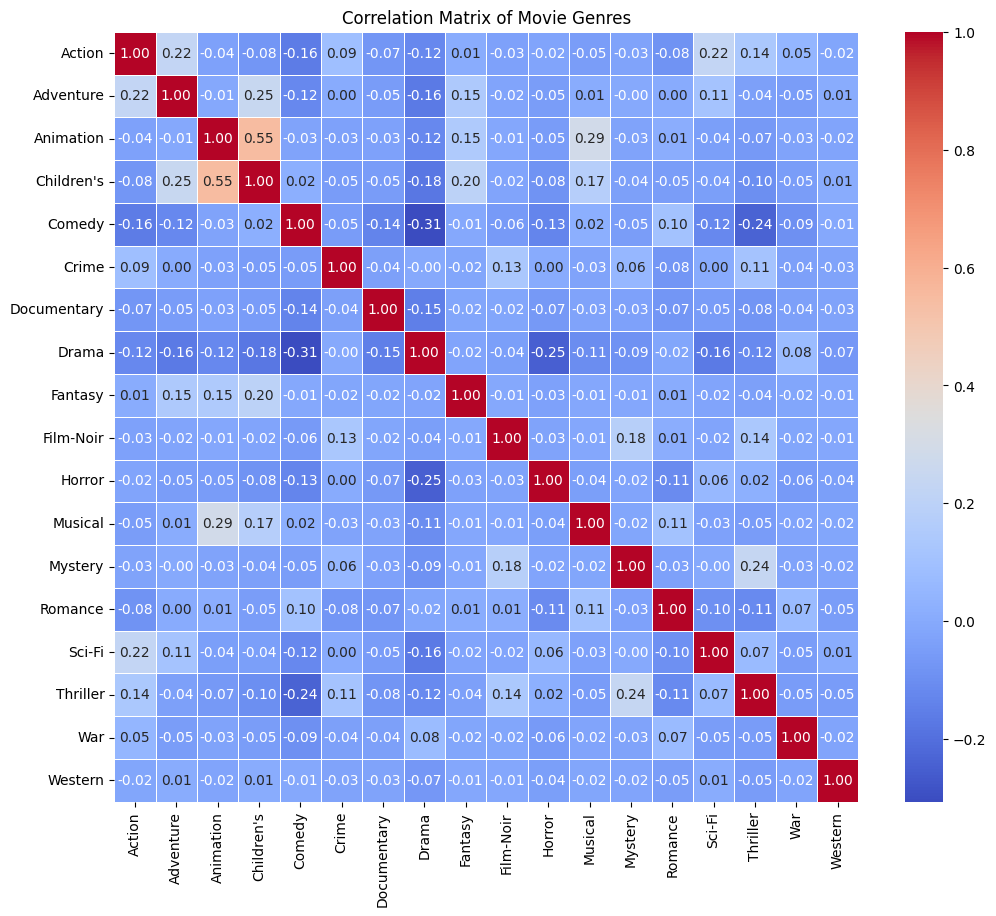

In [20]:
genres_matrix = movies_test['genre'].str.join('|').str.get_dummies('|').corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(genres_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Movie Genres')
plt.show()

In [21]:
threshold = 0.2

strong_correlations = genres_matrix.mask(np.triu(np.ones(genres_matrix.shape), k=1).astype(bool)).stack().sort_values(ascending=False)
filtered_correlations = strong_correlations[(strong_correlations.abs() > threshold) & (strong_correlations.index.get_level_values(0) != strong_correlations.index.get_level_values(1))]

print("Top Strongly Correlated Different Genres:\n")
print(filtered_correlations)

Top Strongly Correlated Different Genres:

Children's  Animation     0.550621
Musical     Animation     0.287646
Children's  Adventure     0.245027
Thriller    Mystery       0.237902
Adventure   Action        0.224513
Sci-Fi      Action        0.224513
Fantasy     Children's    0.201843
Thriller    Comedy       -0.239124
Horror      Drama        -0.247785
Drama       Comedy       -0.306235
dtype: float64


## User & rating

In [22]:
users = pandas.read_csv('../data/ml1m/content/dataset/users.dat', sep='::',
                        engine='python',
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')

ratings = pandas.read_csv('../data/ml1m/content/dataset/ratings.dat', engine='python',
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])

In [23]:
users

gender  age  occupation    zip
userid                               
1           F    1          10  48067
2           M   56          16  70072
3           M   25          15  55117
4           M   45           7  02460
5           M   25          20  55455
...       ...  ...         ...    ...
6036        F   25          15  32603
6037        F   45           1  76006
6038        F   56           1  14706
6039        F   45           0  01060
6040        M   25           6  11106

[6040 rows x 4 columns]

In [24]:
unique_age_values = users['age'].unique()
sorted(unique_age_values)

[1, 18, 25, 35, 45, 50, 56]

In [25]:
unique_occupation_values = users['occupation'].unique()
sorted(unique_occupation_values)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [26]:
ratings

userid  movieid  rating  timestamp
0             1     1193       5  978300760
1             1      661       3  978302109
2             1      914       3  978301968
3             1     3408       4  978300275
4             1     2355       5  978824291
...         ...      ...     ...        ...
1000204    6040     1091       1  956716541
1000205    6040     1094       5  956704887
1000206    6040      562       5  956704746
1000207    6040     1096       4  956715648
1000208    6040     1097       4  956715569

[1000209 rows x 4 columns]

In [27]:
ratings_train = ratings.merge(movies_train[["id", "genre"]], how='inner', on='movieid').merge(users, how='inner', on='userid')
ratings_train

userid  movieid  rating  timestamp    id  \
0            1     1193       5  978300760  1193   
1            1      661       3  978302109   661   
2            1      914       3  978301968   914   
3            1     3408       4  978300275  3408   
4            1     2355       5  978824291  2355   
...        ...      ...     ...        ...   ...   
817419    4211     3768       3  965318885  3768   
817420    4211     3791       2  965319075  3791   
817421    4211     3806       3  965319138  3806   
817422    4211     3840       4  965319197  3840   
817423    4211     3766       2  965319138  3766   

                                   genre gender  age  occupation    zip  
0                                [Drama]      F    1          10  48067  
1       [Animation, Children's, Musical]      F    1          10  48067  
2                     [Musical, Romance]      F    1          10  48067  
3                                [Drama]      F    1          10  48067  
4        [Animation, Children's, Comedy]      F    1          10  48067  
...                                  ...    ...  ...         ...    ...  
817419                     [Action, War]      M   45           5  77662  
817420                           [Drama]      M   45           5  77662  
817421                         [Western]      M   45           5  77662  
817422                          [Horror]      M   45           5  77662  
817423                     [Action, War]      M   45           5  77662  

[817424 rows x 10 columns]

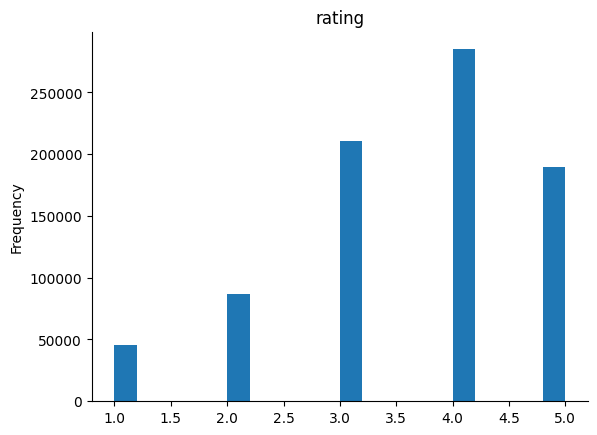

In [28]:
from matplotlib import pyplot as plt
ratings_train['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [46]:
ratings_test = ratings.merge(movies_test[["id", "genre"]], how='inner', on='movieid').merge(users, how='inner', on='userid')
ratings_test

userid  movieid  rating  timestamp    id  \
0            1     2797       4  978302039  2797   
1            1     1270       5  978300055  1270   
2            1       48       5  978824351    48   
3            1      150       5  978301777   150   
4            1     1029       5  978302205  1029   
...        ...      ...     ...        ...   ...   
182403     900     3185       2  975216286  3185   
182404    2722      477       2  973276797   477   
182405    5012     1008       3  962584187  1008   
182406    4158      483       5  965337298   483   
182407    3019     1494       3  970505165  1494   

                                            genre gender  age  occupation  \
0                               [Comedy, Fantasy]      F    1          10   
1                                [Comedy, Sci-Fi]      F    1          10   
2       [Animation, Children's, Musical, Romance]      F    1          10   
3                                         [Drama]      F    1          10   
4                [Animation, Children's, Musical]      F    1          10   
...                                           ...    ...  ...         ...   
182403                                    [Drama]      F   56          13   
182404                                    [Drama]      M   35           7   
182405                                  [Western]      M   50          15   
182406                                    [Drama]      F    1          10   
182407                                   [Comedy]      M   50          12   

          zip  
0       48067  
1       48067  
2       48067  
3       48067  
4       48067  
...       ...  
182403  90066  
182404  22043  
182405  48103  
182406  90039  
182407  97330  

[182408 rows x 10 columns]

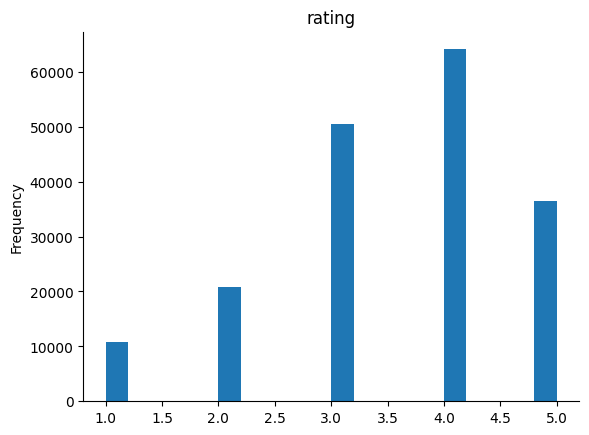

In [30]:
from matplotlib import pyplot as plt
ratings_test['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [31]:


# Tạo một DataFrame mới
movie_info = movies_train.copy()



# Đếm số lượng đánh giá của mỗi phim
movie_info['num_ratings'] = ratings_train.groupby('movieid')['rating'].count()

movie_info['avg_rating'] = ratings_train.groupby('movieid')['rating'].sum()
movie_info['avg_rating'] = movie_info['avg_rating'] / movie_info['num_ratings']

# Đếm số lượng đánh giá của mỗi phim theo giới tính
movie_info['num_female_ratings'] = ratings_train[ratings_train['gender'] == 'F'].groupby('movieid')['rating'].count()
movie_info['num_male_ratings'] = ratings_train[ratings_train['gender'] == 'M'].groupby('movieid')['rating'].count()

# Đếm số lượng đánh giá của mỗi phim theo độ tuổi
for age_value in [1, 18, 25, 35, 45, 50, 56]:
    column_name = f'num_age_{age_value}_ratings'
    movie_info[column_name] = ratings_train[ratings_train['age'] == age_value].groupby('movieid')['rating'].count()

# Đếm số lượng đánh giá của mỗi phim theo nghề nghiệp
for occupation in range(1, 21):  # Giả sử có 20 nghề nghiệp khác nhau
    column_name = f'num_occupation_{occupation}_ratings'
    movie_info[column_name] = ratings_train[ratings_train['occupation'] == occupation].groupby('movieid')['rating'].count()

# Hiển thị DataFrame mới
movie_info.fillna(0, inplace=True)


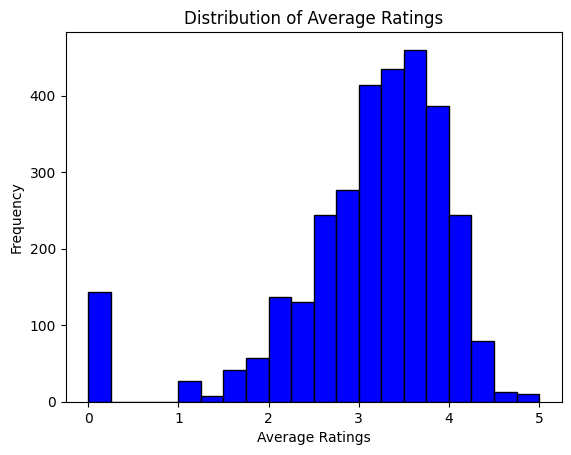

In [44]:
import matplotlib.pyplot as plt

# Filter out NaN values in the 'avg_ratings' column
avg_ratings_not_nan = movie_info['avg_rating'].dropna()

# Plot histogram
plt.hist(avg_ratings_not_nan, bins=20, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Average Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Average Ratings')

# Show the plot
plt.show()


In [48]:


# Tạo một DataFrame mới
movie_info = movies_test.copy()



# Đếm số lượng đánh giá của mỗi phim
movie_info['num_ratings'] = ratings_test.groupby('movieid')['rating'].count()

movie_info['avg_rating'] = ratings_test.groupby('movieid')['rating'].sum()
movie_info['avg_rating'] = movie_info['avg_rating'] / movie_info['num_ratings']

# Đếm số lượng đánh giá của mỗi phim theo giới tính
movie_info['num_female_ratings'] = ratings_test[ratings_test['gender'] == 'F'].groupby('movieid')['rating'].count()
movie_info['num_male_ratings'] = ratings_test[ratings_test['gender'] == 'M'].groupby('movieid')['rating'].count()

# Đếm số lượng đánh giá của mỗi phim theo độ tuổi
for age_value in [1, 18, 25, 35, 45, 50, 56]:
    column_name = f'num_age_{age_value}_ratings'
    movie_info[column_name] = ratings_test[ratings_test['age'] == age_value].groupby('movieid')['rating'].count()

# Đếm số lượng đánh giá của mỗi phim theo nghề nghiệp
for occupation in range(1, 21):  # Giả sử có 20 nghề nghiệp khác nhau
    column_name = f'num_occupation_{occupation}_ratings'
    movie_info[column_name] = ratings_test[ratings_test['occupation'] == occupation].groupby('movieid')['rating'].count()

# Hiển thị DataFrame mới
movie_info.fillna(0, inplace=True)


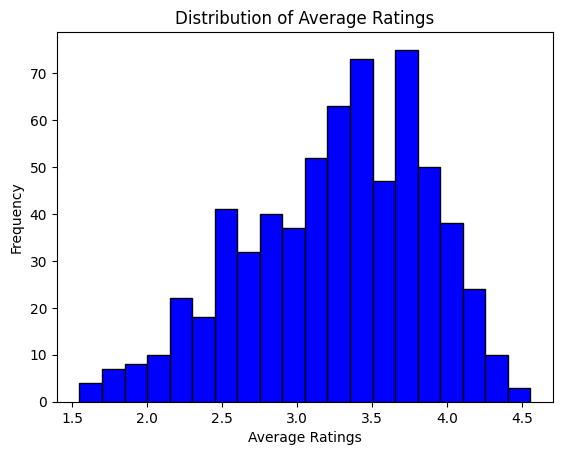

In [49]:
import matplotlib.pyplot as plt

# Filter out NaN values in the 'avg_ratings' column
avg_ratings_not_nan = movie_info['avg_rating'].dropna()

# Plot histogram
plt.hist(avg_ratings_not_nan, bins=20, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Average Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Average Ratings')

# Show the plot
plt.show()


# Images data explore

In [36]:
movies_train = movies_train[movies_train['img_path'] != '']
movies_test = movies_test[movies_test['img_path'] != '']

movies_train_duplicates = movies_train['id'].duplicated()
movies_test_duplicates = movies_test['id'].duplicated()

print(f"Train dataset duplicates: {movies_train_duplicates.any()}")
print(f"Test dataset duplicates: {movies_test_duplicates.any()}")

print(f"Length of train dataset: {len(movies_train)}")
print(f"Length of test dataset: {len(movies_test)}")

Train dataset duplicates: False
Test dataset duplicates: False
Length of train dataset: 2602
Length of test dataset: 654


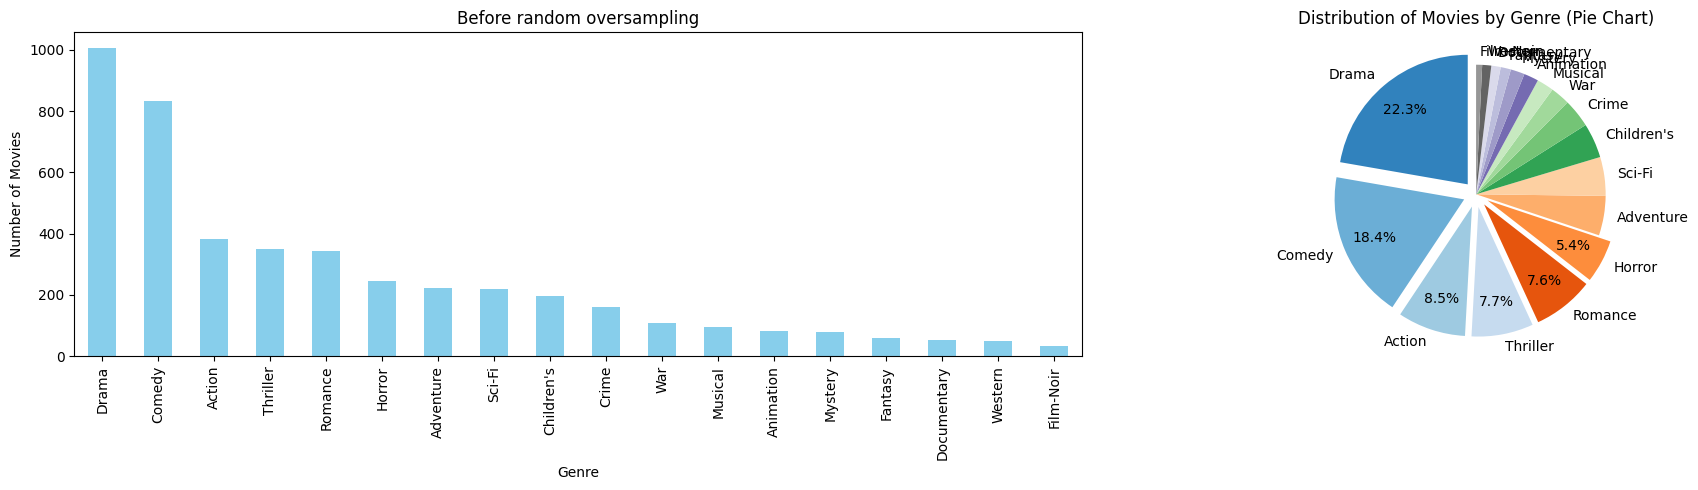

In [37]:
# TRAIN DATA

all_genres = movies_train['genre'].explode()
genre_counts = all_genres.value_counts()

plt.figure(figsize=(20, 5))

# Bar chart
plt.subplot(1, 2, 1)
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Before random oversampling')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')

# Pie chart
plt.subplot(1, 2, 2)
explode = (genre_counts / genre_counts.sum() >= 0.05).astype(float) * 0.1
plt.pie(genre_counts, labels=genre_counts.index, autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
        startangle=90, explode=explode, pctdistance=0.75, colors=plt.cm.tab20c.colors)
plt.title('Distribution of Movies by Genre (Pie Chart)')

plt.tight_layout()
plt.show()

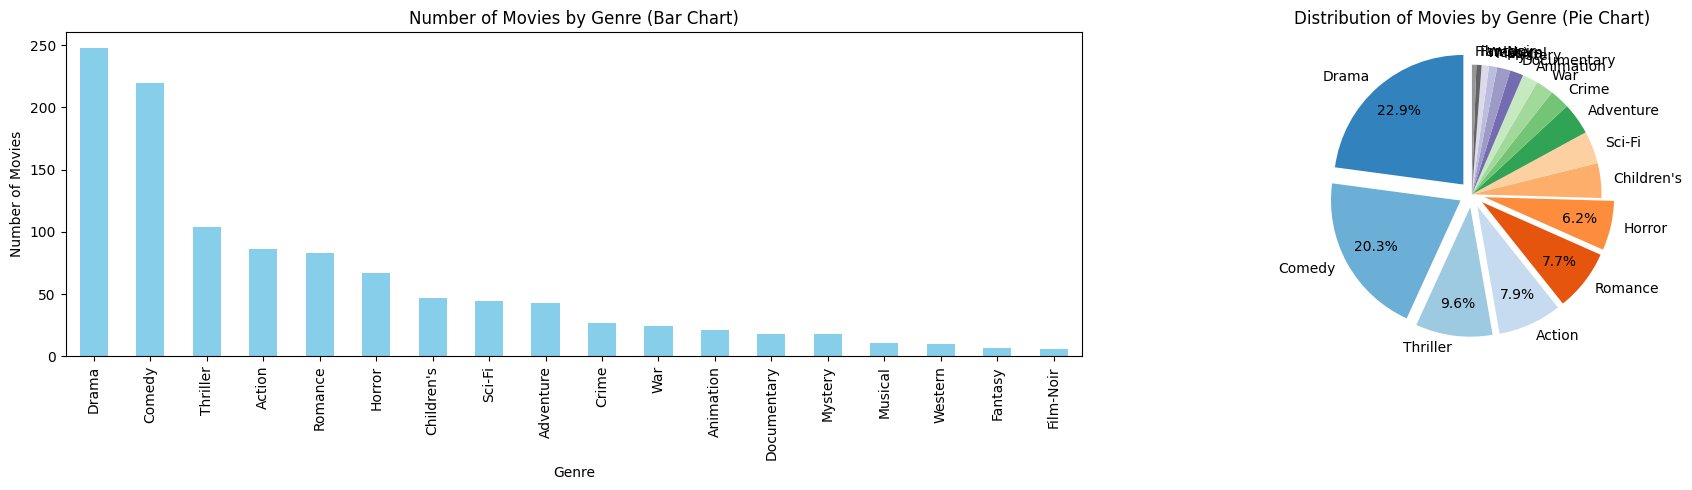

In [38]:
# TEST DATA

all_genres = movies_test['genre'].explode()
genre_counts = all_genres.value_counts()

plt.figure(figsize=(20, 5))

# Bar chart
plt.subplot(1, 2, 1)
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Movies by Genre (Bar Chart)')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')

# Pie chart
plt.subplot(1, 2, 2)
explode = (genre_counts / genre_counts.sum() >= 0.05).astype(float) * 0.1
plt.pie(genre_counts, labels=genre_counts.index, autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
        startangle=90, explode=explode, pctdistance=0.75, colors=plt.cm.tab20c.colors)
plt.title('Distribution of Movies by Genre (Pie Chart)')

plt.tight_layout()
plt.show()

In [39]:
all_genres = movies_train['genre'].explode()
genre_counts = all_genres.value_counts()

print(f"Number of genres: {len(genre_counts)} \n")
print(f"Frequency: \n{genre_counts}")

Number of genres: 18 

Frequency: 
genre
Drama          1007
Comedy          832
Action          384
Thriller        349
Romance         345
Horror          244
Adventure       223
Sci-Fi          219
Children's      196
Crime           161
War             110
Musical          96
Animation        83
Mystery          79
Fantasy          58
Documentary      53
Western          51
Film-Noir        34
Name: count, dtype: int64


In [40]:
def random_oversampling(df, target_samples):
    # dataframe
    oversampled_data = df.copy()
    movies_train_copy = df.copy()
    movies_train_copy = movies_train_copy[~movies_train_copy['genre'].apply(lambda x: True if "Drama" in x else False)]
    movies_train_copy = movies_train_copy[~movies_train_copy['genre'].apply(lambda x: True if "Comedy" in x else False)]

    # oversampling
    genres_list = [
        "Film-Noir",
        "Western",
        "Fantasy",
        "Animation",
        "Mystery",
        "Documentary",
        "Musical",
        "War",
        "Crime",
        "Children's",
        "Sci-Fi",
        "Adventure",
        "Horror",
        "Romance",
        "Thriller",
        "Action",
        "Comedy",
        "Drama"
    ]
    for genre in genres_list:
        if genre in ["Drama", "Comedy"]:
            continue
        
        freq = len(oversampled_data[oversampled_data['genre'].apply(lambda x : True if genre in x else False)])
        oversample_factor = target_samples / freq
        if oversample_factor < 1:
            oversample_factor = 1
        genre_data = movies_train_copy[movies_train_copy['genre'].apply(lambda x: True if genre in x else False)]
        oversampled_genre_data = genre_data.sample(int(freq * (oversample_factor - 1)) + 1, replace=True, random_state=1012)
        oversampled_data = pandas.concat([oversampled_data, oversampled_genre_data])

    # # print
    # gc = oversampled_data['genre'].explode().value_counts()
    # print("\n__________________ RANDOM OVERSAMPLING ________________")
    # print(f"Number of genres: {len(gc)} \n")
    # print(f"Frequency: \n{gc}")
    # print("\n")
    
    return oversampled_data

def upsampling_all(df, factor):
    upsampling_data = df.copy()
    return pandas.concat([upsampling_data] * factor)

In [41]:
new_movies_train = random_oversampling(movies_train, 600)


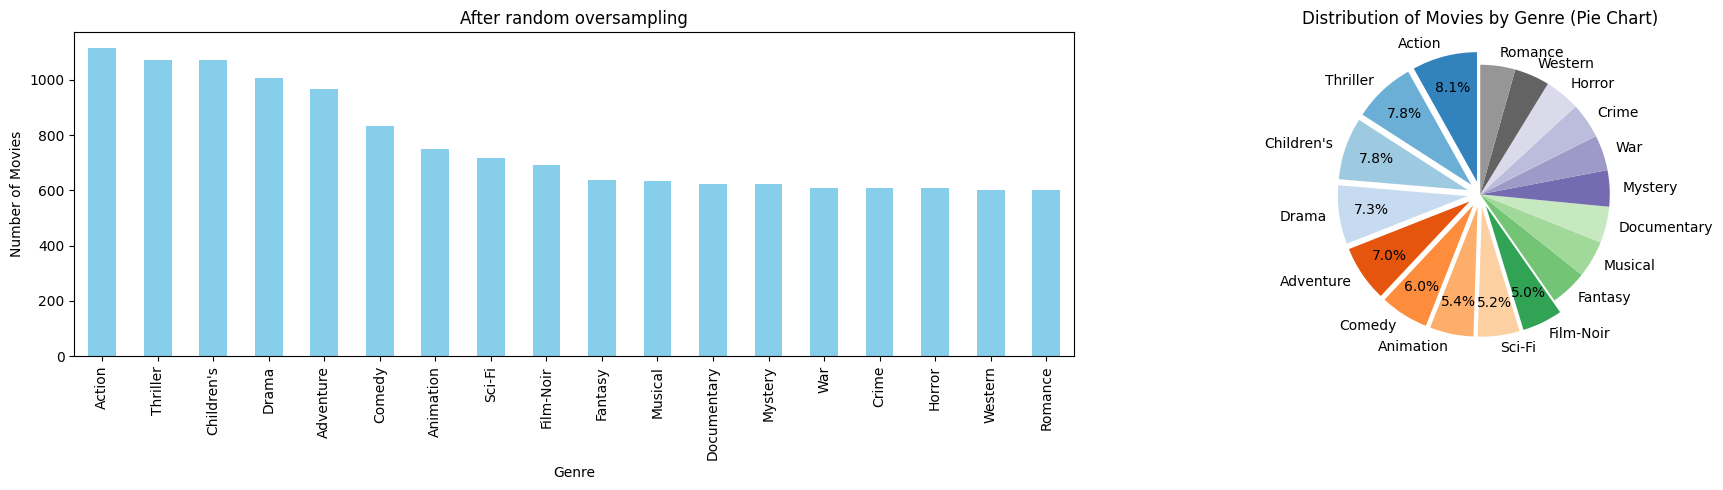

In [42]:
# TRAIN DATA

all_genres = new_movies_train['genre'].explode()
genre_counts = all_genres.value_counts()

plt.figure(figsize=(20, 5))

# Bar chart
plt.subplot(1, 2, 1)
genre_counts.plot(kind='bar', color='skyblue')
plt.title('After random oversampling')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')

# Pie chart
plt.subplot(1, 2, 2)
explode = (genre_counts / genre_counts.sum() >= 0.05).astype(float) * 0.1
plt.pie(genre_counts, labels=genre_counts.index, autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
        startangle=90, explode=explode, pctdistance=0.75, colors=plt.cm.tab20c.colors)
plt.title('Distribution of Movies by Genre (Pie Chart)')

plt.tight_layout()
plt.show()